### Парсинг данных и создание датафрейма

In [37]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

# %matplotlib notebook

In [38]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv")

In [39]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")
    hlines = []
    while True:
        line = f.readline()
        if len(line) == 0 or line[0] != '#':
            break
        hlines.append(line)
    title = hlines[1].replace('#title ', '')[:-1]
    sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
    vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
    columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
    meta_len = len(hlines)
    print(f'Metarows: {meta_len}\nColumns: {columns}')

Headers from file: build/Run0_nt_ParticleData_t0.csv
Metarows: 12
Columns: ['particle_name', 'X', 'Y', 'Z', 'vX', 'vY', 'vZ', 'energy']


In [40]:
data = pd.DataFrame()
for path in paths:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = data.append(item, ignore_index=True)

In [41]:
data

,particle_name,X,Y,Z,vX,vY,vZ,energy
0,e-,-133.04500,81.0331,-36.06310,-0.414359,0.253746,-0.110604,0.202747
1,e-,111.50000,112.5720,-21.52500,0.416829,0.410675,-0.090500,0.271120
2,e-,-60.53540,114.5360,-93.72830,-0.228808,0.411783,-0.352593,0.268335
3,e-,62.94150,-63.2695,-132.67800,0.234554,-0.223248,-0.479264,0.260797
4,e-,-7.08991,116.7700,-109.00700,-0.030055,0.419751,-0.388199,0.256408
...,...,...,...,...,...,...,...,...
4125036,e-,-85.80890,129.5020,-37.86990,-0.308441,0.457587,-0.142497,0.254473
4125037,e-,77.61730,139.7870,-1.79295,0.261473,0.466322,-0.008007,0.228601
4125038,e-,-22.18330,145.7970,61.79990,-0.070620,0.513578,0.214842,0.247965
4125039,e-,-86.00890,71.7960,-114.08700,-0.293367,0.256716,-0.397313,0.244610


In [42]:
set(data["particle_name"])

{'e-', 'gamma'}

In [43]:
len(data[data["particle_name"]=="e-"])

4050414

In [44]:
len(data[data["particle_name"]=="gamma"])

74627

### Отобразим собранные данные

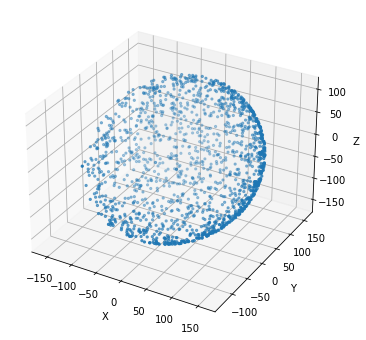

In [45]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[data["particle_name"]=="gamma"]["X"][:1500],
           data[data["particle_name"]=="gamma"]["Y"][:1500],
           data[data["particle_name"]=="gamma"]["Z"][:1500], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Поворот распределения для более удобной работы

In [46]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [47]:
# Матрица поворота вокруг оси х
ang = -np.pi/4 # 45 градусов
Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]

In [115]:
xyz = np.array([np.matmul(point, Mx) for point in xyz])

### Преобразование к полярным координатам

In [121]:
def cart2sph(n_xyz: np.array):
    r = np.sqrt(n_xyz[:, 0]**2 + n_xyz[:, 1]**2 + n_xyz[:, 2]**2)
    θ = np.arccos(n_xyz[:, 2]/r)
    φ = np.arctan2(n_xyz[:, 1], n_xyz[:, 0])
    return np.array([r, θ, φ]).T

def sph2cart(n_rθφ: np.array):
    n_rθφ[:, 2] = n_rθφ[:, 2] % (2*np.pi)
    n_rθφ[:, 1] = n_rθφ[:, 1] % (np.pi)
    x = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.cos(n_rθφ[:, 2])
    y = n_rθφ[:, 0] * np.sin(n_rθφ[:, 1]) * np.sin(n_rθφ[:, 2])
    z = n_rθφ[:, 0] * np.cos(n_rθφ[:, 1])
    return np.array([x, y, z]).T

In [122]:
print(f"θ range: {min(nrθφ[:,1])} to {max(nrθφ[:,1])}")
print(f"φ range: {min(nrθφ[:,2])} to {max(nrθφ[:,2])}")

θ range: 0.0029453424837578607 to 2.7954508843126953
φ range: 0.0002849188667285324 to 6.283184941805996


### Выбор интересующей области

In [123]:
θ_from = np.pi/2-np.pi/10
θ_to = np.pi/2+np.pi/10.

In [124]:
segment, out_segment = [], []
i = 0
j = 0
for r, theta, phi in nrθφ:
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
        i += 1
    else:
        out_segment.append((1, theta, phi))
        j += 1
    
xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))

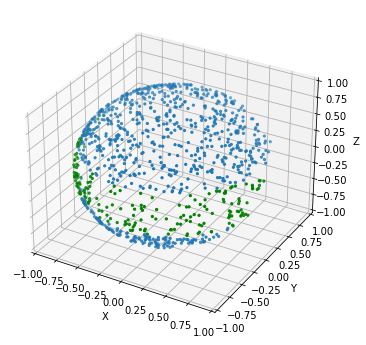

In [125]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*xyz_segment[:200].T, c="green", marker=".")
ax.scatter(*xyz_out_segment[:800].T, marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()

In [126]:
segment_theta = np.array(segment).T[2] # Select TPhi
hist = np.histogram(segment_theta, bins=100)
segment_theta.shape

(24828,)

In [127]:
theta = hist[1][:100]
radii = hist[0]

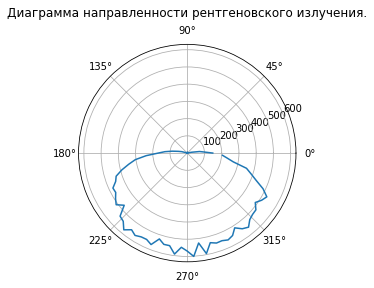

In [128]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, radii)
ax.set_title("Диаграмма направленности рентгеновского излучения.", va='bottom')
plt.show()

### Диаграмма по шаровому поясу

In [70]:
xyz_e = data[data["particle_name"]=="gamma"]
xdata = xyz_e["X"].to_numpy()
ydata = xyz_e["Y"].to_numpy()
zdata = xyz_e["Z"].to_numpy()
endata = xyz_e["energy"].to_numpy()
xyz = np.array([xdata, ydata, zdata]).T

In [71]:
ang = -np.pi/2 # 45 градусов
def rotate(nxyz: np.array, axis: str, ang):
    assert nxyz.shape[1] == 3 # shape == (N, 3)
    Mx = [[1, 0, 0], [0, np.cos(ang), -np.sin(ang)], [0, np.sin(ang), np.cos(ang)]]
    My = [[np.cos(ang), 0, np.sin(ang)], [0, 1, 0], [-np.sin(ang), 0, np.cos(ang)]]
    Mz = [[np.cos(ang), -np.sin(ang), 0], [np.sin(ang), np.cos(ang), 0], [0, 0, 1]]
    M = {"X":Mx, "Y":My, "Z":Mz}
    return np.array([np.matmul(point, M[axis]) for point in nxyz])

In [72]:
xyz = rotate(xyz, "X", np.pi)

In [73]:
xyz.shape

(74627, 3)

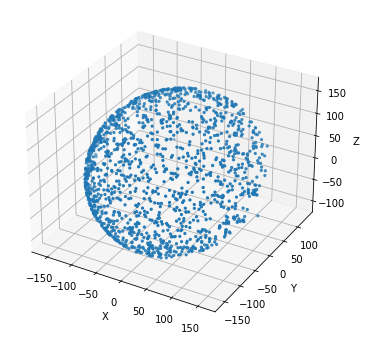

In [74]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:1500,0],
           xyz[:1500,1],
           xyz[:1500,2], marker=".")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Подсчёт по кольцам

In [75]:
nrθφ = cart2sph(xyz)

In [76]:
segments = [], []
dθ = np.pi/12
for r, theta, phi in nrθφ:
    if θ_from<theta and theta<θ_to:
        segment.append((1, theta, phi))
    else:
        out_segment.append((1, theta, phi))

xyz_segment = sph2cart(np.array(segment))
xyz_out_segment = sph2cart(np.array(out_segment))